In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
import torch
from torchviz import make_dot
#!brew install graphbiz    # Only for Mac Users

## Forward and Backward pass without autograd (manually)

Example derived from: https://github.com/jcjohnson/pytorch-examples#pytorch-autograd

In [5]:
device = torch.device('cpu')

In [6]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

In [7]:
# random input and output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Random init of weights
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

In [ ]:
learning_rate = 1e-6

for epoch in range(300):
    # Forward Pass
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    
    # Compute the loss
    loss = (y_pred - y).pow(2).sum()  # scalar
    print(epoch, loss.item())
    
    # Back propagation: 
    # compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h<0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    # grad update using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


## With Autograd + vanilla gradient descent

In [ ]:
device = torch.device('cpu')

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

lr = 1e-6
for epoch in range(300):
    # Forward Pass
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
    # Compute loss
    loss = (y_pred - y).pow(2).sum()
    print(epoch, loss.item())
    
    # USE AUTOGRAD
    # to compute backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()
    
    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= lr * w1.grad
        w2 -= lr * w2.grad
        
        # Manually zero the gradients after running the backward pass
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        w1.grad.zero_()
        w2.grad.zero_()


## With Autograd + Optimizer

In [ ]:
device = torch.device('cpu')

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

lr = 1e-6

optimizer = torch.optim.SGD([w1, w2], lr=lr)

for epoch in range(300):
    # Forward Pass
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
    # Compute loss
    loss = (y_pred - y).pow(2).sum()
    print(epoch, loss.item())
    
    # USE AUTOGRAD
    # to compute backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()
    
    # We are not doing this here
    # Using optimizer to step towards gradient descent and zeroing out grad
#     with torch.no_grad():
#         w1 -= lr * w1.grad
#         w2 -= lr * w2.grad
        
#         w1.grad.zero_()
#         w2.grad.zero_()

    optimizer.step()
    
    optimizer.zero_grad()

## With Autograd + Optimizer + nn.Loss

In [ ]:
device = torch.device('cpu')

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

lr = 1e-6
# Instead of manual loss implementation, Using Torch.nn.<LossFunction>
mse_loss = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD([w1, w2], lr=lr)

y_pred_viz, loss_viz = None, None

for epoch in range(300):
    # Forward Pass
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
    if epoch==1:
        y_pred_viz = make_dot(y_pred)
    
    # Compute loss
    # Instead of manual loss implementation, Using Torch.nn.<LossFunction>
    # loss = (y_pred - y).pow(2).sum()
    loss = mse_loss(y_pred, y)
    print(epoch, loss.item())
    
    if epoch == 1:
        loss_viz = make_dot(loss)
    
    # USE AUTOGRAD
    # to compute backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()
    
    # Using optimizer to step towards gradient descent and zeroing out grad
    optimizer.step()
    optimizer.zero_grad()
y_pred_viz

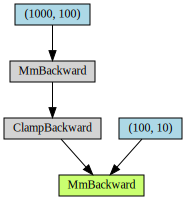

In [31]:
y_pred_viz

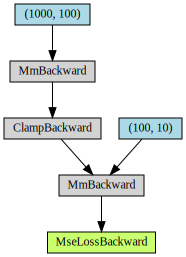

In [32]:
loss_viz

## Using pre-trained models

In [34]:
import torchvision

In [35]:
device = torch.device('cpu')
# Load resnet18 pretrained model
model = torchvision.models.resnet18(pretrained=True)

data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

# Instead of manual loss implementation, Using Torch.nn.<LossFunction>
mse_loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

y_pred_viz_ptm, loss_viz_ptm = None, None

for epoch in range(20):
    y_pred = model(data)
    
    if epoch==1:
        y_pred_viz_ptm = make_dot(y_pred)
    
    # Compute loss
    # Instead of manual loss implementation, Using Torch.nn.<LossFunction>
    # loss = (y_pred - y).pow(2).sum()
    loss = mse_loss(y_pred, labels)
    print(epoch, loss.item())
    
    if epoch==1:
        loss_viz_ptm = make_dot(loss)
    
    # USE AUTOGRAD
    # to compute backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()
    
    # Using optimizer to step towards gradient descent and zeroing out grad
    optimizer.step()
    optimizer.zero_grad()

0 1.0504071712493896
1 1.0173265933990479
2 0.9903337359428406
3 0.8686918020248413
4 0.7391840815544128
5 0.6250073313713074
6 0.5292587280273438
7 0.4459177553653717
8 0.3709213137626648
9 0.3074245750904083
10 0.25193753838539124
11 0.20389877259731293
12 0.16185949742794037
13 0.1259889304637909
14 0.0959504023194313
15 0.07155857980251312
16 0.05159658193588257
17 0.036019690334796906
18 0.024251770228147507
19 0.015653541311621666


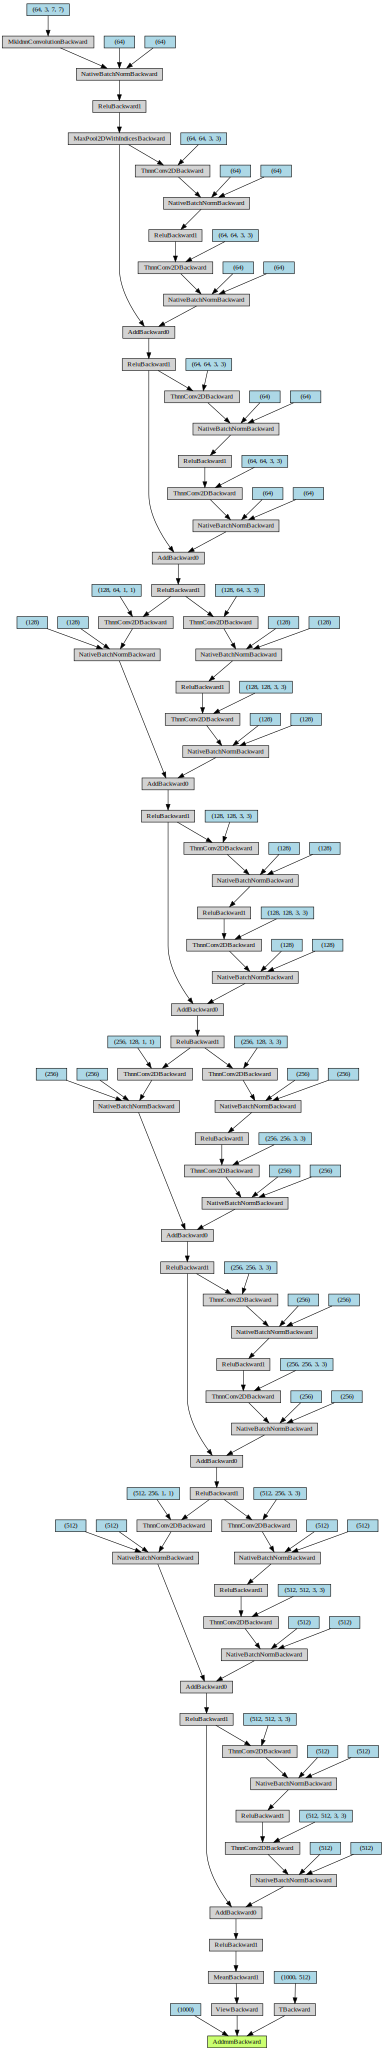

In [38]:
y_pred_viz_ptm

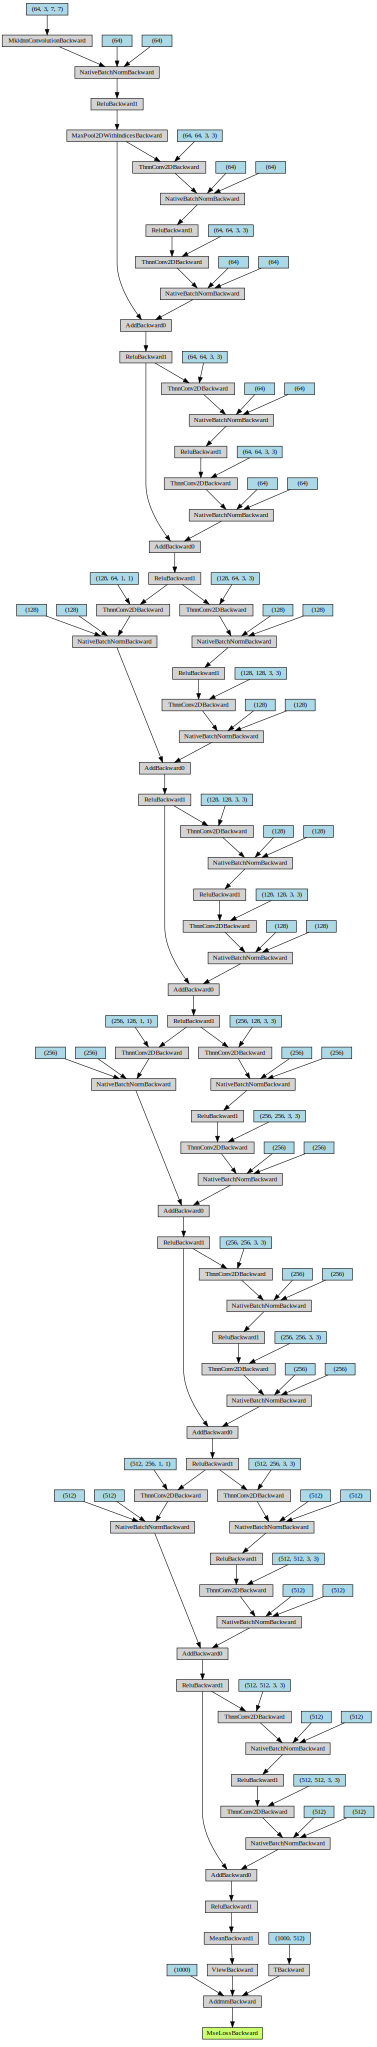

In [39]:
loss_viz_ptm